# DataLoader

In [1]:
from torch.utils.data import DataLoader,random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import numpy as np


datadir='../input/anime-and-cartoon-image-classification/Training Data'

train_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])])

dataset=ImageFolder(datadir,transform=train_transform)
length=len(dataset)
train_size=int(0.8*length)
val_size=length-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])


In [2]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)

# Model

In [1]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)

# Train

In [4]:
output_dir='./resnet50.pth'
device='cuda:0'
epochs=20


val_acc=0.0
best_acc=0.0
train_step=len(train_loader)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
inchannel=model.fc.in_features
model.fc=nn.Linear(inchannel,2)
model.to(device)

loss_fn=nn.CrossEntropyLoss()
params=[p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.Adam(params,lr=0.0005)
for epoch in range(epochs):
    model.train()
    train_loss=0.0
    for i,(images,labels) in enumerate(train_loader):
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        predict=model(images)
        loss=loss_fn(predict,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    
    
    model.eval()
    correct=0
    val_loss=0.0
    with torch.no_grad():
        for i,(images,labels) in enumerate(val_loader):
            images,labels=images.to(device),labels.to(device)
            predict=model(images)
            loss=loss_fn(predict,labels)
            val_loss+=loss.item()
            predict_y=torch.max(predict,dim=1)[1]
            correct+=torch.eq(predict_y,labels).sum().item()
    val_acc=correct/len(val_dataset)
    print('epoch:{} train loss:{:.4f} val loss:{:.4f} val acc；{:.3f}'.format(epoch,train_loss/len(train_dataset),val_loss/len(val_dataset),val_acc))

    if val_acc>best_acc:
        best_acc=val_acc
        torch.save(model.state_dict(),output_dir)
    print('finish training!')
            
            

# Predict

In [131]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def predict():
    device = 'cpu'
    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = "test/cartoon/red hat.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    class_indict={'0':'anime','1':'cartoon'}

    # create model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    inchannel=model.fc.in_features
    model.fc=nn.Linear(inchannel,2)

    model.load_state_dict(torch.load('resnet50.pth'),strict=True)

    # prediction
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


Using cache found in C:\Users\daye/.cache\torch\hub\pytorch_vision_v0.10.0


class: anime        prob: 0.000343
class: cartoon      prob: 1.0


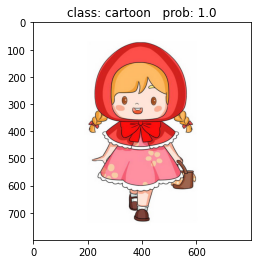

In [132]:
predict()